In [1]:
import numpy as np
import os
import scipy.io
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
data_dir = 'data/'
subject = 1
subject_dataset = 1
subject_file = f'S{subject}_E1_A{subject_dataset}.mat'  #S1_E1_A1.mat
mat = scipy.io.loadmat(os.path.join(data_dir,subject_file))

In [3]:
glove = mat['glove']

FS = 2000
N_CH = mat['emg'].shape[1]

rec_duration = mat['emg'].shape[0]/FS
rec_time = np.arange(0,rec_duration, 1/FS)


# loading into df for easier handling
emg_df = pd.DataFrame(mat['emg'])
emg_df['time'] = rec_time
emg_df['restimulus'] = mat['restimulus']
emg_df['stimulus'] = mat['stimulus']
emg_df['rerepetition'] = mat['rerepetition']

# Using stimulus or restimulus here would mean different things. It changes the duration of each trial. 
emg_df['trial'] = (emg_df['restimulus'] != emg_df['restimulus'].shift()).cumsum()
emg_df['glove'] = glove[:,5]

emg_index = emg_df.loc[(emg_df['trial']<62) & (emg_df['trial']>=41) ]

# Custom function to calculate RMS with whatever window size and overlap of 1 step. This can be replaced with whatever RMS calculator 

In [4]:
def window_rms(a, window_size):
  a2 = np.power(a,2)
  window = np.ones(window_size)/float(window_size)
  return np.sqrt(np.convolve(a2, window, 'same'))

### Apply RMS to each channel and also **NORMALIZING TO 0-1**

In [5]:
emg_rms = emg_df.iloc[:,0:N_CH]

for channel_id in range(16):
#     channel_id = 0
    emg_rms.iloc[:,channel_id] = window_rms(emg_df.iloc[:,channel_id],1000)
    emg_rms.iloc[:,channel_id] /= np.max(emg_rms.iloc[:,channel_id])
    


In [6]:
stimulus_list = emg_df['restimulus'].unique()

### Plotting the rms for all channels across trials for a given stimulus

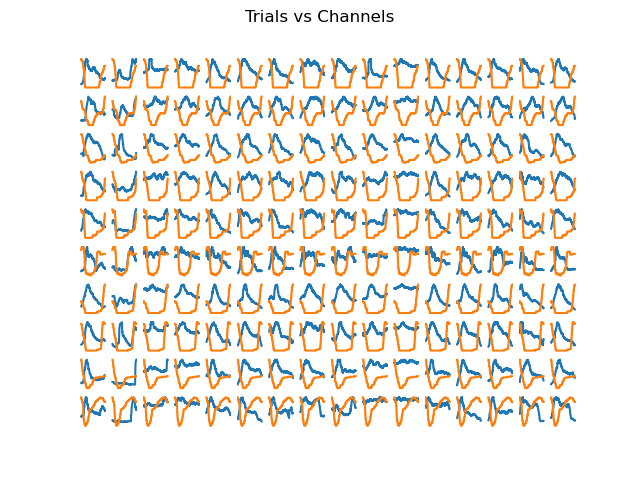

In [7]:
# n is the stimulus index. Based on the emg_df["stimulus"] or emg_df["restimulus"]
n = 5
fig, axs = plt.subplots(10,16)
fig.suptitle('Trials vs Channels')
i=0

#Glove data of 5th channel
emg_df['glove'] = glove[:,5]

#The trial numbers of a given stimulus
for trial in range(20*n + 2, 20*(n+1) + 2, 2):
    
    emg_rms_stimulus = emg_rms[emg_df['trial']==trial]
    emg_df_stimulus = emg_df[emg_df['trial']==trial]
    for j in range(16):
        axs[i,j].plot(emg_rms_stimulus.iloc[:,j])
        axs[i,j].plot(np.max(emg_rms_stimulus.iloc[:,j])* (emg_df_stimulus['glove']-np.min(emg_df_stimulus['glove']))/(np.max(emg_df_stimulus['glove'])-np.min(emg_df_stimulus['glove'])))
        
        axs[i,j].set_axis_off()

    i = i+ 1
plt.show()
    

### Plotting the first trial of each stimulus across all the channels, to see if there is any variability

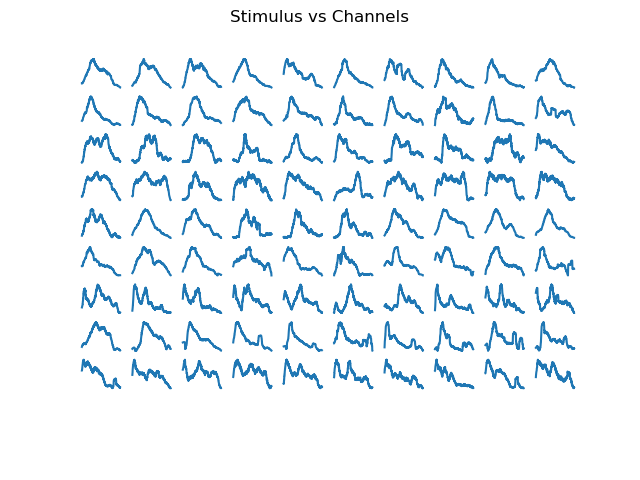

In [8]:
fig, axs = plt.subplots(10,10)
fig.suptitle('Stimulus vs Channels')


for i in range(10):
    
    for j in range(10):
        emg_rms_stimulus = emg_rms[emg_df['trial']==20*i+2 +2*j]
        emg_df_stimulus = emg_df[emg_df['trial']==20*i+2 + 2*j]
        axs[i,j].plot(emg_rms_stimulus.iloc[:,6])
        
        axs[i,j].set_axis_off()

#     i = i+ 1
plt.show()
    

## Generating spikes from RMS for Stimuli

This is currently not placing positive and negative spikes in separate channels. It just keeps it in the same channel 

In [10]:
import math

stimulus_list = [1,2,3,4,5,6,7,8,9]
X_train = []
Y_train = []

# This is the band width of each amplitude threshold. So if your rms is between 0 and 1. Band_Size of 0.1 will
# split it into 10 amplitude bands. 
maximum_rms_value = 1
band_size = 0.1
num_thresholds = 10 # math.floor(maximum_rms_value/band_size)

# For each stimulus
for stimulus in range(len(stimulus_list)):
    trial_idx = 0

    # For each trial in the stimulus
    for trial in range(20*stimulus + 2, 20*(stimulus+1) + 2, 2):
        
        #Extract the original data as well as the RMS data from that particular trial of that particular stimulus
        emg_rms_stimulus = emg_rms[emg_df['trial']==trial]
        emg_df_stimulus = emg_df[emg_df['trial']==trial]
        
        # Create a list for holding events from the trial
        events = []
        
        # For each channel in the EMG signal
        for channel in range(16):
            
            # Get the RMS time series of the channel
            channel_signal = np.asarray(emg_rms_stimulus.iloc[:,channel])
            timesteps = channel_signal.shape[0]
            
            # Variable to store the current threshold
            curr_threshold = math.floor(channel_signal[0]*10)
            
            
            for timestep in range(timesteps):
                # Convert the channel signal into the specific amplitude threshold range
                threshold_level = math.floor(channel_signal[timestep]/band_size)

                # Cut off the amplitude threshold range to only from 0-9.
                # Everything above it considered to be in level 9. This should be changed 
                # if the RMS value is not normalized between 0 and 1
                if threshold_level >= num_thresholds:
                        threshold_level = num_thresholds -1

                # Check if the signal jumped. 
                if threshold_level != curr_threshold:
                    curr_threshold = threshold_level
                    # Add an event
                    events.append([channel*num_thresholds + threshold_level,timestep])

        # Sorting the spikes based on the timestamps of the events. 
        X_train.append(sorted(events, key=lambda x: x[1]))
        Y_train.append(stimulus)
            


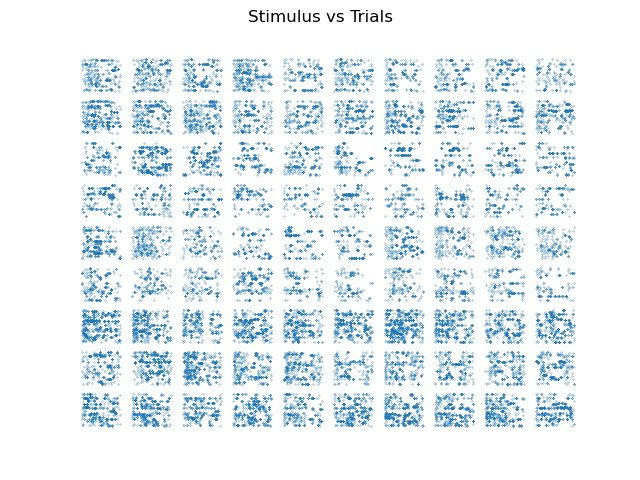

In [13]:
# for n in stimulus_list:
n = 1
fig, axs = plt.subplots(9,10)
fig.suptitle('Stimulus vs Trials')
i=0
for i in range(9):
    
    for j in range(10):
        events = np.asarray(X_train[10*i+j])

        axs[i,j].plot(events[:,1],events[:,0],'.',markersize=0.5)
        axs[i,j].set_axis_off()

plt.show()
    

In [14]:
import pickle
with open('all_channels_one_hundred_sixty_spikes_X_train.pkl', 'wb') as f:  
    pickle.dump(X_train, f)
    
with open('all_channels_one_hundred_sixty_spikes_Y_train.pkl', 'wb') as f:  
    pickle.dump(Y_train, f)

In [200]:
with open('all_channels_one_hundred_sixty_spikes_X_train.pkl', 'rb') as f:
    X = pickle.load(f)
    
with open('all_channels_one_hundred_sixty_spikes_Y_train.pkl', 'rb') as f:
    Y = pickle.load(f)
    

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1) 